# Modefied code from Lecture 7 to run simulations with the AS-Oregon data

In [20]:
from abc import ABC, abstractmethod
import networkx as nx
import random
from random import shuffle
import matplotlib.pyplot as plt
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout

from calculateLambda import obtainMaxEig

%matplotlib inline

### Abstract Agent Class and 2 Agent types

In [116]:
beta = 0.5
gamma = 0.2
print(beta/gamma)

2.5


In [117]:
#Parent Abstract class
class GenericAgent(ABC):
    #Made this an abstract method
    @abstractmethod
    def __init__(self,gid,atype):

        
        #Posible state 0-Suceptible,, 1-Infected, 2-Recovered
        self.state=0
        self.next_state=0
        
        #Id in the simulation
        self.gid=gid
        
        #Agent type
        self._atype=atype
        
        #Probability of starting to smoke per interaction
        self._beta=0
        
        #Probability of stopping to smoke
        self._gamma=0
        
        #Position of the agent in the map (can be ignored, the position is changed when the graph is created)
        self.plotSpacewidth=3
        self.position=[self.gid%self.plotSpacewidth,self.gid//self.plotSpacewidth]
        
        super().__init__()
    def perceive(self,environment):
        perception=[]
        #The perception consists of the neighbors of the agent and their state
        for neigh in environment.neighbors(self.gid):
            #print("--- ",neigh," state ",G.nodes[neigh]['data'].state)
            perception.append(environment.nodes[neigh]['data'].state)
        return perception
    
    def act(self,perception):
        #Assumed Kermack-McKendrick SIR model
    
        next_state=self.state
        
        if self.state != 2:
            #For every neighbor it interacts with
            for val in perception:
                #if the neighbor is Infected, the current agent will get infected with prob self.beta
                if val == 1:
                    sample=np.random.uniform(0,1)
                    if self._beta>sample:
                        next_state=1

            #if the agent itself is Infected, it will Recover with probability self.gamma
            if self.state == 1:
                sample=np.random.uniform(0,1)
                #print(sample)
                if self._gamma>sample:
                    #print(self._gamma," --- ",sample, " --- ",self._gamma<sample)
                    next_state=2
                
        #The states are updated at the end of the time-step        
        self.next_state=next_state
    
    def update(self):
        #Updating step
        self.state=self.next_state

            
    def info(self):
        print("Agent ",self.gid," of type ",self._atype," state ",self.state, " at position ",self.position)

#Specialized, agent type A (0)        
class AgentA(GenericAgent):
    def __init__(self,gid):
        super().__init__(gid,0)
        self._beta=beta
        self._gamma=gamma

#Specialized agent type B (1)
class AgentB(GenericAgent):
    def __init__(self,gid):
        super().__init__(gid,1)
        self._beta=beta
        self._gamma=gamma
        
    


### Function to initialise the Population and read in the data

In [118]:
def InitializeAgentPopulation(path, elementSeparator, threasholdA, max_number_of_people, number_of_infected_people, largest_eig =False):
    G = nx.Graph()
    sourceFile = open(path, "r")
    edgelist = []
    Agentlist = []
    i = 0
    while(i<=max_number_of_people):
        line = sourceFile.readline()
        if line == '' or line == '\n':
            break
        uv = tuple([(int(j)) for j in line.split(elementSeparator)])
        if (uv[0]<max_number_of_people and uv[1]<max_number_of_people):
            edgelist.append(uv)
            i+=1
    sourceFile.close()
    
    
    #TODO: Vielleicht das Maximum aus max_number_of_people und der Anzahl, die Wirklich in dem file enthalten sind
    for i in range(max_number_of_people):
        if i >= threasholdA:
            Agentlist.append(AgentA(i))
        else:
            Agentlist.append(AgentB(i))
            
    for i in range(number_of_infected_people):
        Agentlist[random.randint(0,max_number_of_people+1)].state=1
    
    for agent in Agentlist:
        G.add_node(agent.gid,data=agent)
    
    G.add_edges_from(edgelist)
    
    #for nicer plotting
    pos = nx.random_layout(G, dim=2)    
    for i in range(len(Agentlist)):
        Agentlist[i].position[0]=pos[i][0]
        Agentlist[i].position[0]=pos[i][1] 
    if largest_eig ==True:
        Gtilde = nx.Graph()
        Gtilde.add_edges_from(edgelist)
        eig  = obtainMaxEig(Gtilde, False, 2)
        return Agentlist, G, 3
    
    return Agentlist, G
    

### Helper function to plot the graph

In [119]:
#Plots the interaction graph with the states used as a color map
def PlotGraph(G,color_map=None,ax=None):
    #Extract the positions
    if color_map is None: 
        color_map = [node[1]['data'].state for node in G.nodes(data=True)]
    
    #Change numerical values for colors
    for i in range(len(color_map)):
        if color_map[i] == 0:
            color_map[i] = "green"
        if color_map[i] == 1:
            color_map[i] = "red"
        if color_map[i] == 2:
            color_map[i] = "blue"
    
    pos = {node[0]: (node[1]['data'].position[0],node[1]['data'].position[1]) for node in G.nodes(data=True)}
        
    #Plot on a specific figure or not    
    if ax is None:
        nx.draw(G,pos,node_color = color_map, with_labels=True, font_weight='bold', node_size = 1000)
    else:
        nx.draw(G,pos,node_color = color_map, ax=ax, with_labels=True, font_weight='bold', node_size = 1000)

### Function defining what happens at each time-step

In [120]:
def step(AgentList,Environment):
    #Agents need to be shuffled to eliminate the unrealistic advantage of having a lower gid
    shuffle(AgentList)
    
    #Execute all agents
    for agent in AgentList:
        #print("Executing agent ",agent.gid)
        perception = agent.perceive(Environment)
        agent.act(perception)
        
    #Update all agents
    for agent in AgentList:
        agent.update()
        #agent.info()

### Function defining what happens during the simulation

In [121]:
def simulate(AgentList,Environment,numSteps):
    #Store the initial state
    simResults=[[node[1]['data'].state for node in Environment.nodes(data=True)]]
    
    #Perform numSteps number of steps
    for i in range(numSteps):
        #print("Step ",i," of numSteps")
        step(AgentList,Environment)
        
        #Store results
        states = [node[1]['data'].state for node in Environment.nodes(data=True)]
        simResults.append(states)
    return simResults

## Create Model -> TODO: Ersetzen durch eigene Simulation mit gegebenen Graphen

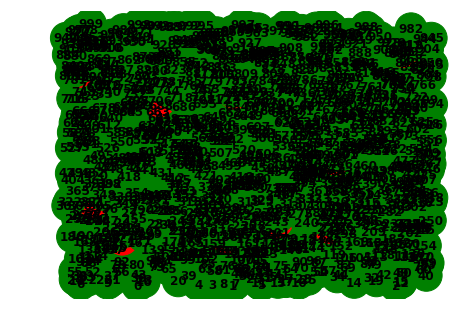

In [122]:
AgentList, Environment, eig =InitializeAgentPopulation("data/asgraph/asgraph.txt", ':', 3, 1000, 10, largest_eig = True)
#TODO: schöneren Graphen
PlotGraph(Environment)

## Execute Simulation

In [123]:
print(eig)
print(eig*beta/gamma)

3
7.5


In [124]:
nSteps=20
results=simulate(AgentList,Environment,nSteps)

### Visualize Results

In [125]:
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
from copy import deepcopy
import pandas as pd

In [126]:
%%capture
# Build plot
fig, ax = plt.subplots(figsize=(6,4))
resultsCopy= deepcopy(results)

def animate(j):
    ax.clear()
    PlotGraph(Environment,color_map=resultsCopy[j],ax=ax)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

In [127]:
ani

In [128]:
df = pd.DataFrame(results)

In [129]:
S = df[df==0].count(axis='columns')
I = df[df==1].count(axis='columns')
R = df[df==2].count(axis='columns')

In [130]:
x = np.arange(0.0, nSteps+1, 1)

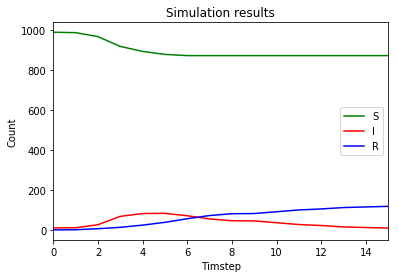

In [131]:
plt.plot(x,S,'green', label='S')
plt.plot(x,I,'red', label='I')
plt.plot(x,R,'blue', label='R')
plt.xlabel('Timstep')
plt.xlim(0,15)
plt.ylabel('Count')
plt.title('Simulation results')
plt.legend()
plt.show()

In [132]:
import pip

def install(package):
    if hasattr(pip, 'main'):
        pip.main(['install', package])
    else:
        pip._internal.main(['install', package])

# Example
#if __name__ == '__main__':
#    install('argh')

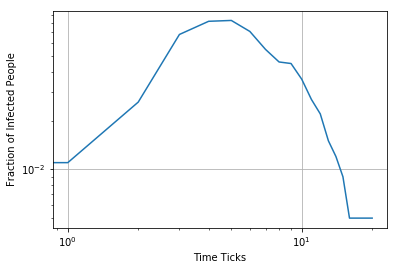

In [133]:
plt.loglog(x, I/(S+I+R))
plt.grid()
plt.xlabel("Time Ticks")
plt.ylabel("Fraction of Infected People")
plt.show()

In [135]:
print(R)

0       0
1       1
2       6
3      13
4      24
5      38
6      56
7      72
8      81
9      82
10     91
11    100
12    105
13    112
14    115
15    118
16    122
17    122
18    122
19    122
20    122
dtype: int64
